In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Cargamos el archivo .npz
data = np.load("dataset_rutas_etiqueta.npz", allow_pickle = True)

train_rutas = data["train_rutas"].tolist()
train_etiquetas = data["train_etiquetas"].tolist()
test_rutas = data["test_rutas"].tolist()
test_etiquetas = data["test_etiquetas"].tolist()
val_rutas = data["val_rutas"].tolist()
val_etiquetas = data["val_etiquetas"].tolist()

In [5]:
# Pruebas para validar el dataset
print(np.unique(test_etiquetas))
conteo = {}

for x in train_etiquetas:
    conteo[x] = conteo.get(x, 0) + 1

print(conteo)

[0 1]
{1: 30574, 0: 42000}


In [6]:
# Pasamos los datos a tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_rutas, train_etiquetas))
test_ds  = tf.data.Dataset.from_tensor_slices((test_rutas, test_etiquetas))
val_ds  = tf.data.Dataset.from_tensor_slices((val_rutas, val_etiquetas))

# Cargamos y preprocesamos
IMG_SIZE = 224 #Hay que hacer pruebas para decir el tamaño 224 es un poco el estandar, probar relacion pixels -> accuracy
BATCH_SIZE = 64

def load_and_preprocess(ruta, etiqueta):
    img = tf.io.read_file(ruta)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)/255.0
    return img, etiqueta


train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) 
test_ds  = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds  = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(3000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

(64, 224, 224, 3)
tf.Tensor(
[1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0], shape=(64,), dtype=int32)


(-0.5, 223.5, 223.5, -0.5)

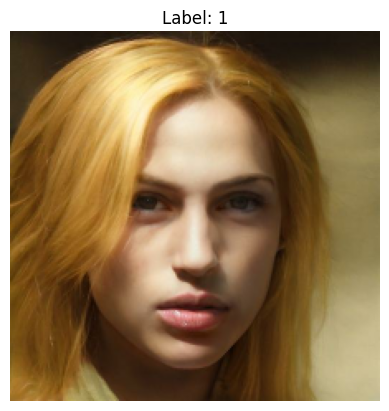

In [7]:
# Para comprobar que se ha hecho bien el preprocesamiento y evaluar el tamaño de las imagenes
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels)


plt.imshow(images[0])
plt.title(f"Label: {labels[0].numpy()}")
plt.axis("off")


In [8]:
# Creamos el modelo
model = Sequential()

# 1 Capa - Convolucional + Pooling
model.add(Conv2D(32,kernel_size=(3,3), padding = "same", input_shape = (224,224,3), activation='relu'))
model.add(MaxPooling2D())
# 2 Capa - Convolucional + Pooling
model.add(Conv2D(64,kernel_size=(3,3), padding = "same", activation='relu'))
model.add(MaxPooling2D())
# 3 Capa - Convolucional + Pooling
#model.add(Conv2D(128,kernel_size=(3,3), padding = "same", activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar antes de las capas densas
model.add(Flatten())

#Capas densas
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [9]:
epochs = 10
learning_rate = 0.0001

model.compile(
    optimizer=Adam(learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy'] #, 'AUC','f1_score','precision','recall']
)

# Entrenamos el modelo
history = model.fit(train_ds, validation_data = val_ds, epochs=epochs,verbose=1)

Epoch 1/10
1134/1134 [==============================] - 338s 293ms/step - loss: 0.4592 - accuracy: 0.7892 - val_loss: 0.3343 - val_accuracy: 0.8704
Epoch 2/10
1134/1134 [==============================] - 346s 295ms/step - loss: 0.2846 - accuracy: 0.8908 - val_loss: 0.2567 - val_accuracy: 0.9067
Epoch 3/10
1134/1134 [==============================] - 315s 271ms/step - loss: 0.2271 - accuracy: 0.9156 - val_loss: 0.2215 - val_accuracy: 0.9188
Epoch 4/10
1134/1134 [==============================] - 367s 308ms/step - loss: 0.1925 - accuracy: 0.9300 - val_loss: 0.2328 - val_accuracy: 0.9055
Epoch 5/10
1134/1134 [==============================] - 268s 228ms/step - loss: 0.1689 - accuracy: 0.9403 - val_loss: 0.1873 - val_accuracy: 0.9328
Epoch 6/10
1134/1134 [==============================] - 339s 291ms/step - loss: 0.1477 - accuracy: 0.9481 - val_loss: 0.1868 - val_accuracy: 0.9314
Epoch 7/10
1134/1134 [==============================] - 301s 257ms/step - loss: 0.1340 - accuracy: 0.9530 - val_

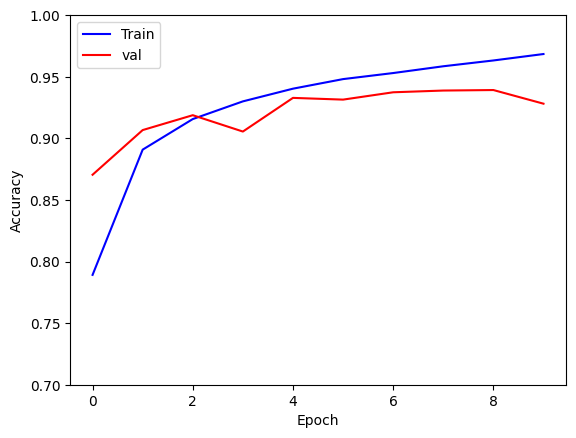

In [14]:
plt.plot(history.history['accuracy'],'b')
plt.plot(history.history['val_accuracy'],'r')
plt.legend(['Train','val'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)  # Forzar eje y entre 0 y 1
plt.show()

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    # predecir sobre el batch
    probs = model.predict(images, verbose=0)
    preds = (probs > 0.5).astype(int)
    
    # guardar etiquetas y predicciones
    y_true.append(labels.numpy())
    y_pred.append(preds)

# convertir a un solo array (más pequeño que X_test completo)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


Accuracy: 0.9304257957833816
Confusion matrix:
 [[12959  1041]
 [  642  9548]]


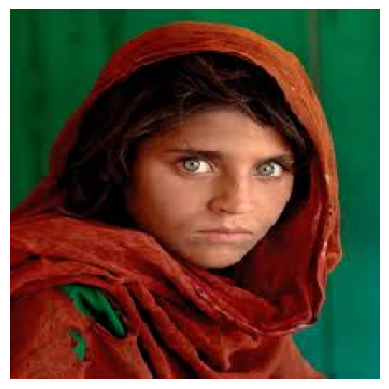

1/1 [==============================] - 0s 28ms/step
Raw prediction: [[1]]


In [16]:
# Probamos la prediccion con una imagen cualquiera
from tensorflow.keras.preprocessing import image

# Ruta de la imagen nueva
img_path = r"C:\Users\Claudia Ada\Downloads\descarga.jfif"
 # <-- cambia esto

# Cargar imagen
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))

# Convertir a array
img_array = image.img_to_array(img)

# Normalizar (igual que entrenamiento)
img_array = img_array / 255.0

# Añadir dimensión batch
img_array = np.expand_dims(img_array, axis=0)

# Mostrar imagen
plt.imshow(img)
plt.axis("off")
plt.show()

prediction = model.predict(img_array)
pred_final = (prediction > 0.5).astype(int)

print("Raw prediction:", pred_final)

In [15]:
model.save("modelo_completo.keras")